In [16]:
pip install tensorflow_addons

In [15]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tensorflow_addons as tfa

In [17]:
# load the whole dataset, for data info
all_ds   = tfds.load("eurosat", with_info=True)
# load training, testing & validation sets, splitting by 60%, 20% and 20% respectively
train_ds = tfds.load("eurosat", split="train[:60%]")
test_ds  = tfds.load("eurosat", split="train[60%:80%]")
valid_ds = tfds.load("eurosat", split="train[80%:]")

In [18]:
# the class names
class_names = all_ds[1].features["label"].names
# total number of classes (10)
num_classes = len(class_names)
num_examples = all_ds[1].splits["train"].num_examples

Text(0.5, 1.0, 'Bar Plot showing Number of Samples on Each Class')

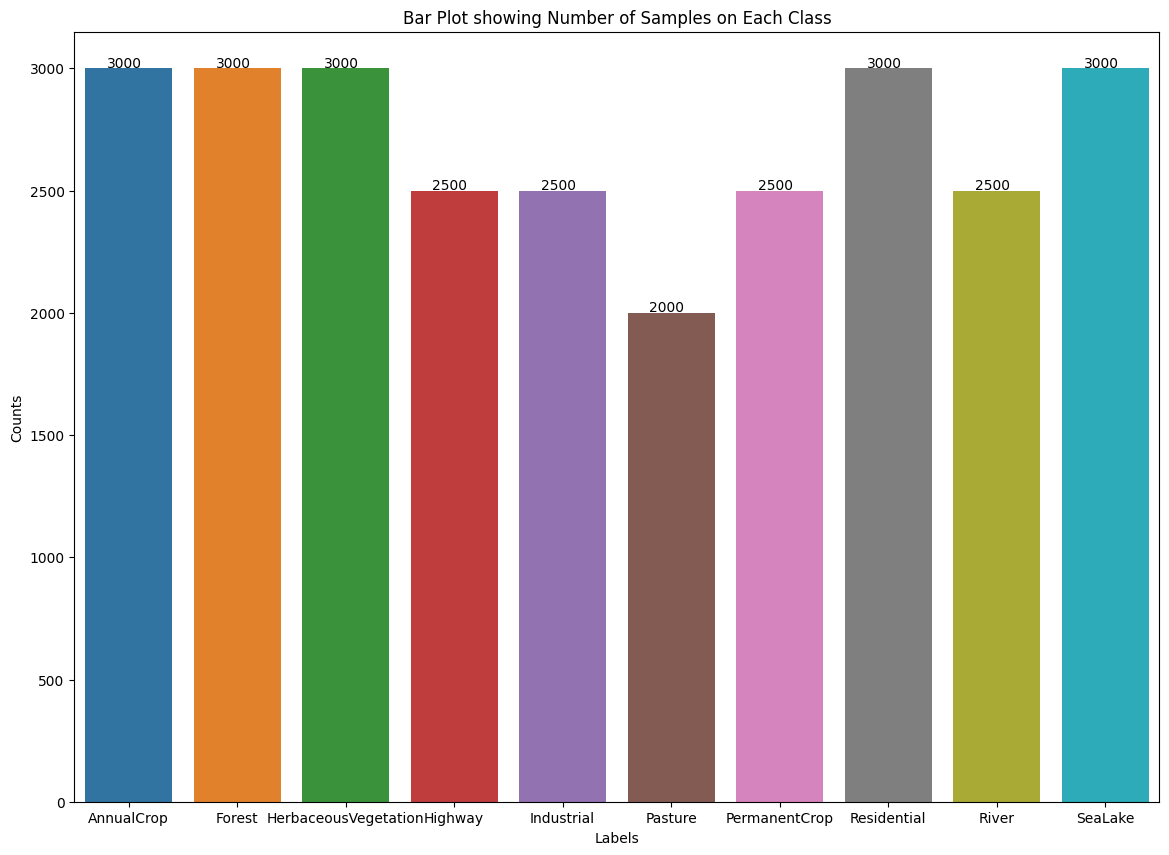

In [19]:
# make a plot for number of samples on each class
fig, ax = plt.subplots(1, 1, figsize=(14,10))
labels, counts = np.unique(np.fromiter(all_ds[0]["train"].map(lambda x: x["label"]), np.int32),
                       return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Labels')
sns.barplot(x = [class_names[l] for l in labels], y = counts, ax=ax)
for i, x_ in enumerate(labels):
  ax.text(x_-0.2, counts[i]+5, counts[i])
# set the title
ax.set_title("Bar Plot showing Number of Samples on Each Class")
# save the image
# plt.savefig("class_samples.png")

In [20]:
def prepare_for_training(ds, cache=True, batch_size=64, shuffle_buffer_size=1000):
  if cache:
    if isinstance(cache, str):
      ds = ds.cache(cache)
    else:
      ds = ds.cache()
  ds = ds.map(lambda d: (d["image"], tf.one_hot(d["label"], num_classes)))
  # ds = ds.map(lambda d: (d["sentinel2"], tf.one_hot(d["label"], num_classes)))
  # shuffle the dataset
  ds = ds.shuffle(buffer_size=shuffle_buffer_size)
  # Repeat forever
  ds = ds.repeat()
  # split to batches
  ds = ds.batch(batch_size)
  # `prefetch` lets the dataset fetch batches in the background while the model
  # is training.
  ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return ds

In [21]:
batch_size = 64

# preprocess training & validation sets
train_ds = prepare_for_training(train_ds, batch_size=batch_size)
valid_ds = prepare_for_training(valid_ds, batch_size=batch_size)

In [22]:
# validating shapes
for el in valid_ds.take(1):
  print(el[0].shape, el[1].shape)
for el in train_ds.take(1):
  print(el[0].shape, el[1].shape)

(64, 64, 64, 3) (64, 10)
(64, 64, 64, 3) (64, 10)


In [23]:
batch = next(iter(train_ds))

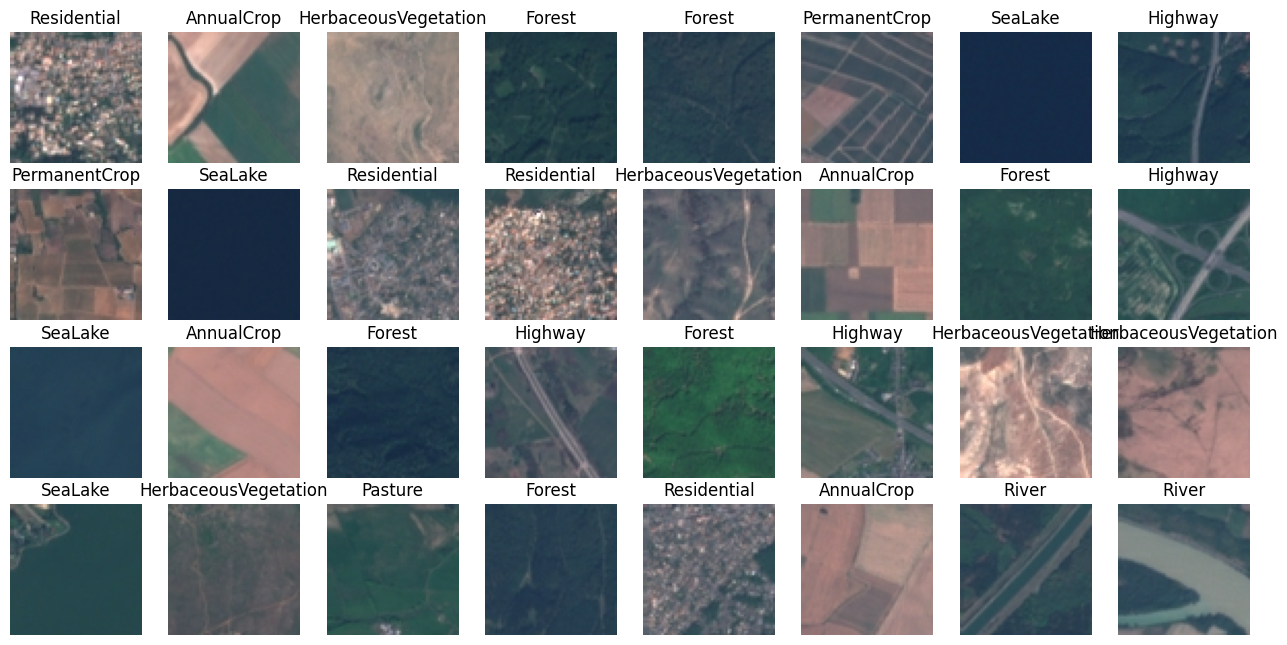

In [14]:
def show_batch(batch):
  plt.figure(figsize=(16, 16))
  for n in range(min(32, batch_size)):
      ax = plt.subplot(batch_size//8, 8, n + 1)
      # show the image
      plt.imshow(batch[0][n])
      # and put the corresponding label as title upper to the image
      plt.title(class_names[tf.argmax(batch[1][n].numpy())])
      plt.axis('off')
      plt.savefig("sample-images.png")

# showing a batch of images along with labels
show_batch(batch)

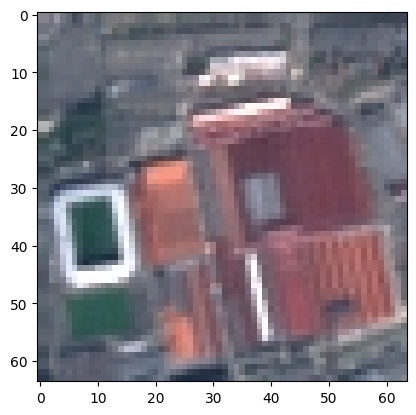

In [24]:
plt.imshow(batch[0][1])

In [25]:
model_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2"

# download & load the layer as a feature vector
keras_layer = hub.KerasLayer(model_url, output_shape=[1280], trainable=True)

In [26]:
m = tf.keras.Sequential([
  keras_layer,
  tf.keras.layers.Dense(num_classes, activation="softmax")
])
# build the model with input image shape as (64, 64, 3)
m.build([None, 64, 64, 3])
m.compile(
    loss="categorical_crossentropy",
    optimizer="adam",
    metrics=["accuracy", tfa.metrics.F1Score(num_classes)]
)

In [27]:
m.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              117746848 
                                                                 
 dense (Dense)               (None, 10)                12810     
                                                                 
Total params: 117,759,658
Trainable params: 117,247,082
Non-trainable params: 512,576
_________________________________________________________________


In [28]:
model_name = "satellite-classification"
model_path = os.path.join("results", model_name + ".h5")
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_path, save_best_only=True, verbose=1)
print(model_path)
print(model_checkpoint)

results/satellite-classification.h5


In [29]:
# set the training & validation steps since we're using .repeat() on our dataset
# number of training steps
n_training_steps   = int(num_examples * 0.6) // batch_size
# number of validation steps
n_validation_steps = int(num_examples * 0.2) // batch_size

In [ ]:
# train the model
history = m.fit(
    train_ds, validation_data=valid_ds,
    steps_per_epoch=n_training_steps,
    validation_steps=n_validation_steps,
    verbose=1, epochs=5,
    callbacks=[model_checkpoint]
)

Epoch 1/5
 38/253 [===>..........................] - ETA: 2:02:03 - loss: 0.8140 - accuracy: 0.7385 - f1_score: 0.7284